In [1]:
#image segmentation

#naive method first

import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def display(img, cmap = None):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap=cmap)

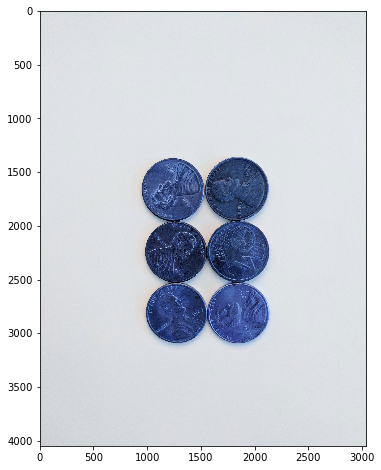

In [48]:
#coin example - tough to separate by naive method

sep_coins = cv2.imread('../DATA/pennies.jpg')
display(sep_coins)

In [4]:
#process = Med blur, grayscale, threshold, contours

sep_blur = cv2.medianBlur(sep_coins, 35)

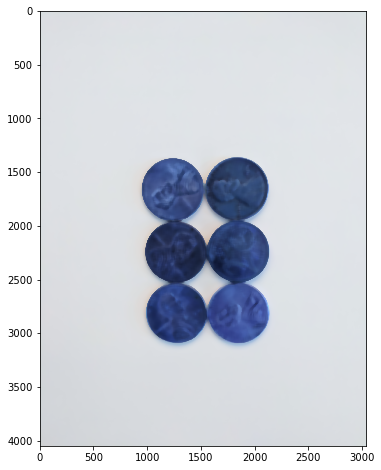

In [5]:
display(sep_blur)

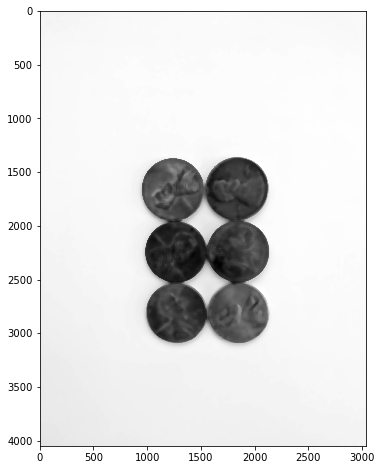

In [6]:
sep_gray = cv2.cvtColor(sep_blur, cv2.COLOR_BGR2GRAY)
display(sep_gray, cmap = 'gray')

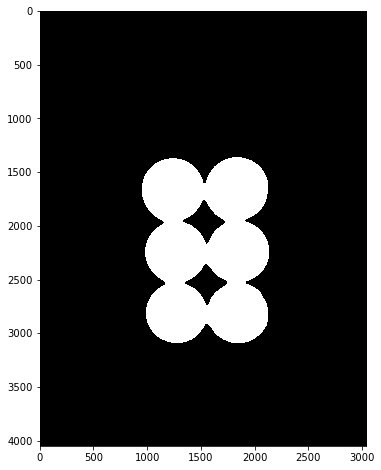

In [7]:
#applying an inverse threshold

ret, sep_thresh = cv2.threshold(sep_gray, 160, 255, cv2.THRESH_BINARY_INV)
display(sep_thresh, cmap = 'gray')

In [8]:
#contours

image, contours, hierarchy = cv2.findContours(sep_thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

In [9]:
for i in range(len(contours)):
    
    if hierarchy[0][i][3] == -1: #ext contours
        cv2.drawContours(sep_coins, contours, i, (255, 0, 0), 10)
        

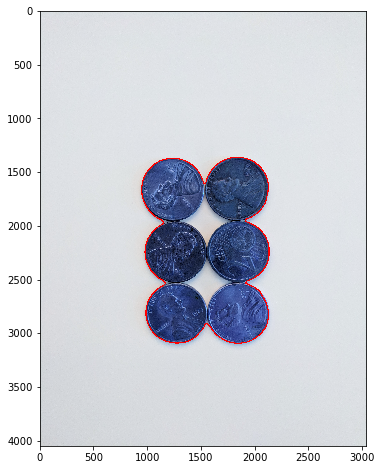

In [11]:
display(sep_coins)  #it treats the contour as one single entity and not indiv, hence use watershed

In [13]:
################## WATERSHED ALGO #################

In [14]:
#read ip img

img = cv2.imread('../DATA/pennies.jpg')

In [15]:
#medianBlur

img = cv2.medianBlur(img, 35)

In [16]:
#to gray

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

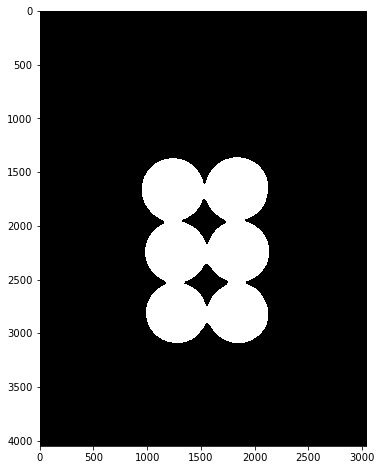

In [18]:
#threshold, inv bin along with OTSU - used with the watershed algo

ret, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
display(th, cmap = 'gray')

In [20]:
#remove noise - optional stage - do it by opening (erosion + dilation)

kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(th, cv2.MORPH_OPEN,kernel, iterations = 2)

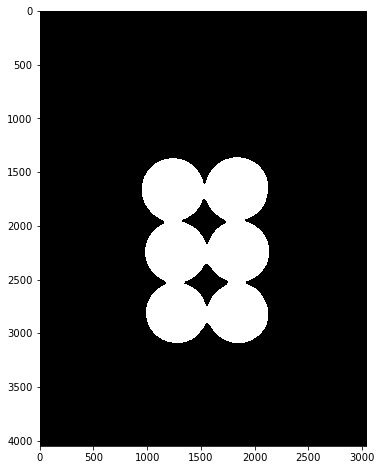

In [21]:
display(opening, cmap = 'gray')

In [26]:
#need to segment using seeds which are the valleys from which the cols are let to flow

#sep the sure bg and sure fg
#to get the sure bg we can use dilate where we expand the white until we hit some limit

sure_bg = cv2.dilate(opening, kernel, iterations= 3)

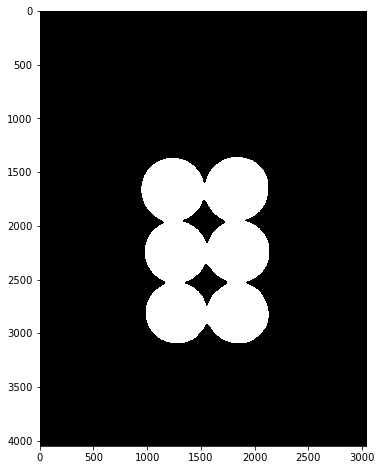

In [27]:
display(sure_bg, cmap = 'gray')

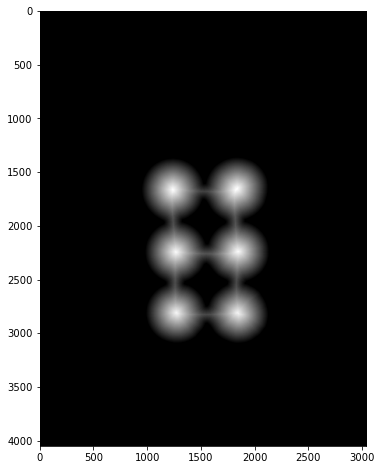

In [29]:
#get the sure foreground

dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
display(dist_transform, cmap = 'gray') #note that in d transform the outer black stay as it is and as we move away the values starts to rise and peak at white

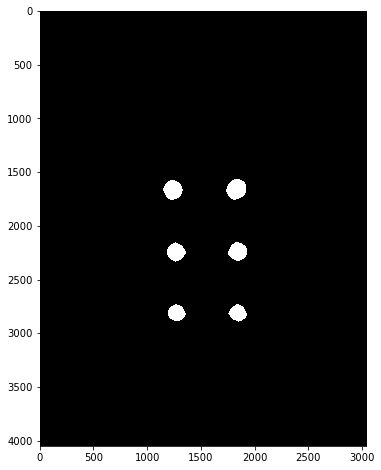

In [31]:
ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
display(sure_fg, cmap = 'gray')

In [32]:
sure_fg

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [33]:
sure_bg

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [34]:
#unknown region is diff between the sure bg and the sure fg

sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

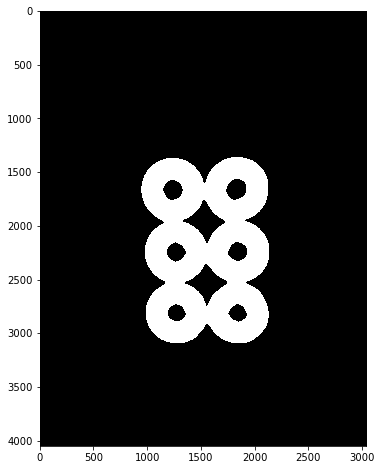

In [35]:
display(unknown, cmap = 'gray')

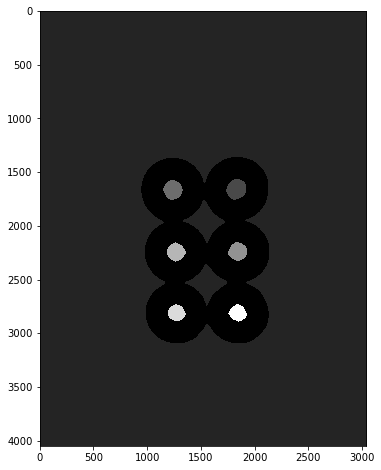

In [39]:
#we need to set the seed as the sure fg for the watershed algo
ret, markers = cv2.connectedComponents(sure_fg)

markers = markers + 1  # Add one to all labels so that sure background is not 0, but 1

markers[unknown == 255] = 0    # Now, mark the region of unknown with zero

display(markers, cmap = 'gray')



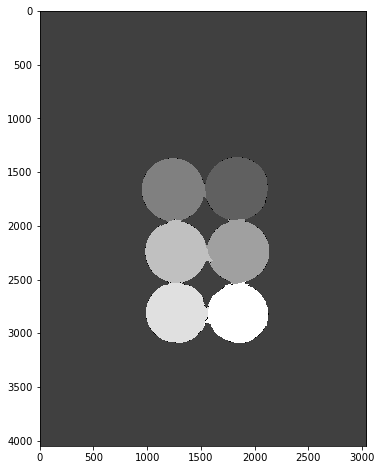

In [41]:
#we have the seed and now apply the watershed

markers = cv2.watershed(img, markers)
display(markers, cmap = 'gray')

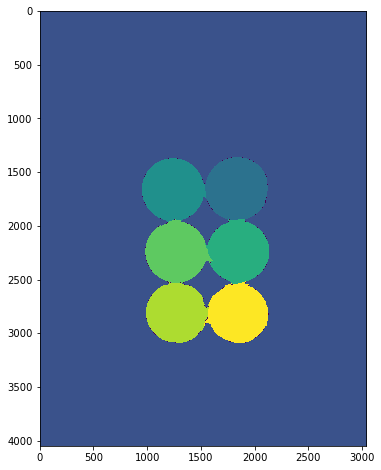

In [42]:
markers = cv2.watershed(img, markers)
display(markers)

In [49]:
#now we can draw contours

image, contours, hierarchy = cv2.findContours(markers.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

for i in range(len(contours)):
    
    if hierarchy[0][i][3] == -1:
        
        cv2.drawContours(sep_coins, contours, i, (255, 0, 0), 10)

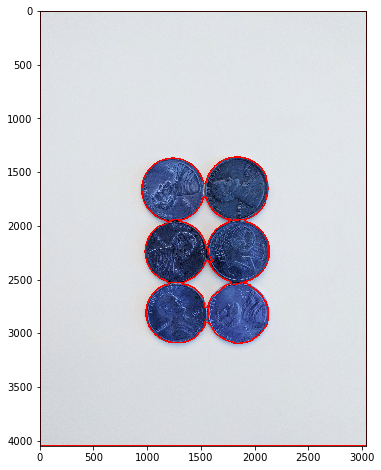

In [50]:
display(sep_coins)